In [1]:
import numpy as np
import torch
import torch.nn as nn
from matplotlib import pyplot as plt
from tqdm import tqdm
import seaborn as sns

In [2]:
def get_dynamics(n=5, n_steps=1000):
    """Get dynamics under a sparse matrix.
    
    Args:
        n: dimensionality
        n_steps: number of steps to generate
    
    """
    # initial state
    state = np.random.randn(n)

    # permutation of 1..n to fill elements in the matrix in
    p = np.random.permutation(range(n))

    # the transition dynamics matrix
    A = np.zeros((n, n))

    # filling in the elements
    A[range(n), p] = np.random.choice([-1, 1], size=n)

    # doing a rollout under the defined dynamics
    states = [np.array(state)]

    for _ in range(n_steps):
        # computing next state
        state = A @ state
        # saving the state
        states.append(np.array(state))

    # converting to a numpy array
    states = np.array(states)
    
    return states
    
    
def get_encoder(n_out, n):
    """Get a linear encoder matrix
    
    Args:
        n_out: output observation dimensionality
        n: input state dimensionality
    
    """
    W = np.random.randn(n_out, n)
    return W

def encode(states, encoder_matrix):
    """Encode states with an encoder."""

    X = (states @ encoder_matrix.T)
    return X

In [3]:
# state dim
n = 5

# obs dim
k = 100

# features dim
f = 5

# number of steps to generate
n_steps = 1000

# encoder matrix
encoder = get_encoder(n_out=k, n=n)

In [4]:
# obtaining the states
states = get_dynamics(n=n, n_steps=n_steps)

# compute observations
observations = encode(states, encoder)

In [5]:
observations.shape

(1001, 100)

In [44]:
class LinearNet(nn.Module):
    """Linear neural network."""
    
    def __init__(self, inp_dim, out_dim, add_batch_norm=False):
        super(LinearNet, self).__init__()
        self.fc1 = nn.Linear(in_features=inp_dim, out_features=out_dim,
                           bias=False)
        if add_batch_norm:
            self.batch_norm = torch.nn.BatchNorm1d(num_features=out_dim)
        
    def forward(self, x):
        x = self.fc1(x)
        if hasattr(self, 'batch_norm'):
            x = self.batch_norm(x)
        return x

In [45]:
def reconstruction_loss(obss, decoder, reconstructor):
    """Ensure that the decoder is not degenerate by fitting a reconstructor."""
    mse = torch.nn.MSELoss()
    return mse(reconstructor(decoder(obss)), obss)

def reconstruction_loss_norm(reconstructor):
    """Ensure that the decoder is not degenerate (inverse norm not too high)."""
    regularization_loss = 0
    for param in reconstructor.parameters():
        regularization_loss += torch.sum(torch.square(param))
    return regularization_loss

def fit_loss(obss, decoder, model):
    """Ensure that the model fits the features data."""
    mse = torch.nn.MSELoss()
    
    return mse(model(decoder(obss[:-1])), decoder(obss[1:]))

def sparsity_loss(model):
    """Ensure that the model is sparse."""
    regularization_loss = 0
    for param in model.parameters():
        regularization_loss += torch.sum(torch.abs(param))
    return regularization_loss

In [46]:
def losses(obss_torch, decoder, reconstructor, model, rn_threshold=100):
    """Compute all losses ob observations."""
    res = {}
    res['r'] = reconstruction_loss(obss_torch, decoder, reconstructor)
    res['f'] = fit_loss(obss_torch, decoder, model)
    res['s'] = sparsity_loss(model)
    res['rn'] = reconstruction_loss_norm(reconstructor)
    if res['rn'] < rn_threshold:
        res['rn'] = torch.from_numpy(np.array(rn_threshold))
    return res

def total_loss(losses_, hypers):
    """Compute total loss."""
    loss = 0.0
    for key in hypers.keys():
        loss += hypers[key] * losses_[key]
    return loss

def lstdct2dctlst(lst):
    """List of dictionaries -> dict of lists."""
    keys = lst[0].keys()
    result = {k: [] for k in keys}
    for item in lst:
        for k, v in item.items():
            result[k].append(v)
    return result

def epoch(obss_torch, decoder, reconstructor, model, hypers):
    """One optimization epoch."""
    optimizer.zero_grad()
    L = losses(obss_torch, decoder, reconstructor, model)
    loss = total_loss(L, hypers)
    loss.backward()
    optimizer.step()
    L['total'] = loss
    return {x: y.item() for x, y in L.items()}

def metrics(decoder, reconstructor, model, hypers):
    m = {}
    m['nnz'] = np.sum(np.abs(list(model.parameters())[0].detach().numpy().flatten()) > 1e-2)
    m['hyper_s'] = hypers['s']
    return m

In [65]:
hypers = {'r': 0.1, 'f': 0.2, 's': 0.0001, 'rn': 0.0001}
k, f

(100, 5)

In [71]:
# creating models
decoder = LinearNet(inp_dim=k, out_dim=f, add_batch_norm=True)
reconstructor = LinearNet(inp_dim=f, out_dim=k)
model = LinearNet(inp_dim=f, out_dim=f)

#### Optimizing via total loss over the whole data

In [72]:
# converting observations to torch
obss_torch = torch.from_numpy(np.array(observations, dtype=np.float32))

In [73]:
all_parameters = list(model.parameters()) + list(decoder.parameters()) + list(reconstructor.parameters())
optimizer = torch.optim.Adam(all_parameters, lr=1e-3)

In [74]:
# training
last_hyper_adjustment = -1
results = []
for i in tqdm(range(5000)):
    e = epoch(obss_torch, decoder, reconstructor, model, hypers)
    e.update(metrics(decoder, reconstructor, model, hypers))
    results.append(e)
    
    if e['r'] + e['f'] > 1e-2:
        if hypers['s'] > 1e-5:
            suggested_hyper = hypers['s'] * 0.5
    else:
        if hypers['s'] < 10:
            suggested_hyper = hypers['s'] / 0.5
            
    if i - last_hyper_adjustment >= 100:
        hypers['s'] = suggested_hyper
        last_hyper_adjustment = i

100%|██████████| 5000/5000 [00:10<00:00, 479.73it/s]


findfont: Font family ['cmsy10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmr10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmtt10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmmi10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmb10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmss10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmex10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['DejaVu Sans Display'] not found. Falling back to DejaVu Sans.


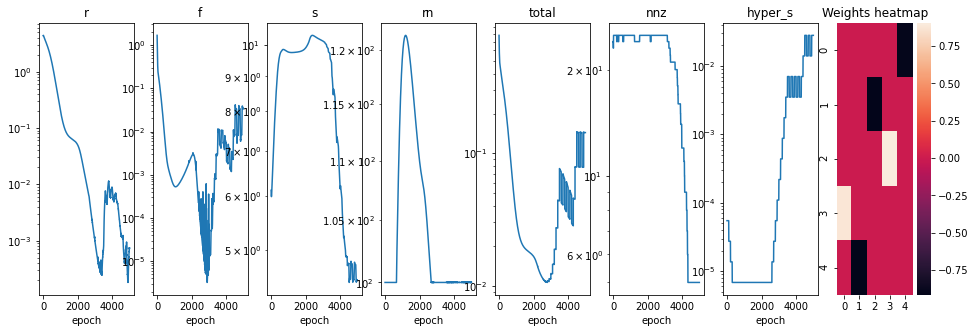

In [76]:
# plotting
plt.figure(figsize=(16, 5))
for i, (k_, v) in enumerate(lstdct2dctlst(results).items()):
    plt.subplot(1, len(results[0]) + 1, i + 1)
    plt.xlabel('epoch')
    plt.title(k_)
    plt.axhline(0)
    plt.plot(v)
    plt.yscale('log')
    
plt.subplot(1, len(results[0]) + 1, len(results[0]) + 1)
plt.title("Weights heatmap")
sns.heatmap(list(model.parameters())[0].detach().numpy())

In [25]:
from scipy.special import expit

In [37]:
x = np.array([-1, -2, 0, 1,2,3])

In [38]:
x / (1 + x)

/home/sergei/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


array([      -inf, 2.        , 0.        , 0.5       , 0.66666667,
       0.75      ])

In [ ]:
Add batch normalization!!
or fix the model to be 0/1/-1 (what about scale of features?)
can't do this fully...

F = 0.5 f

(array([ 3.,  0.,  0.,  0., 20.,  0.,  0.,  0.,  0.,  2.]),
 array([-0.94629395, -0.7547017 , -0.5631094 , -0.37151712, -0.17992485,
         0.01166743,  0.2032597 ,  0.39485198,  0.58644426,  0.77803653,
         0.9696288 ], dtype=float32),
 <a list of 10 Patch objects>)

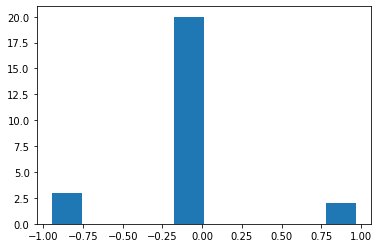

In [64]:
plt.hist(list(model.parameters())[0].detach().numpy().flatten())